## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#con)
- [Refernces](#ref)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. We will be working on a data set for a website which is trying to make a decision if they should change to their new landing page or should they stick to the old one.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('landing_page == "new_page" and group == "control"').shape[0] + df.query('landing_page == "old_page" and group == "treatment"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
drop_idx = df.query("landing_page == 'new_page' and group == 'control'").index
drop_idx2 = df.query("landing_page == 'old_page' and group == 'treatment'").index
total_dropidx = drop_idx.append(drop_idx2)
df2= df.drop(total_dropidx)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#dropping the duplicated user
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

#recheck for duplicates
df2[df2.user_id.duplicated()].user_id

Series([], Name: user_id, dtype: int64)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2.query('group == "control"')['converted'].mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2.query('group == "treatment"')['converted'].mean()
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]


0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

### Probability Conclusion

 
**If we checked all the results from the above calculations we will find that the two groups are equal in size. The probability of conversion in the control group around .12. As for treatment group the probability slightly drops to .119. This slight change is in favor of the control group. However I don’t think that it’s sufficient at all to make conclusion that new page leads to more conversions. I think we may need to do some more testing**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$ :$P_{new}$ - $P_{old}$ <= 0**

**$H_{1}$ :$P_{new}$ - $P_{old}$ > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new), p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old), p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff_new_old = (new_page_converted.mean()) - (old_page_converted.mean())
diff_new_old

0.0032807655697183746

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new), p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old), p_old])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

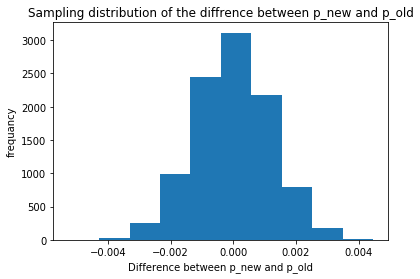

In [26]:
plt.hist(p_diffs);
plt.xlabel('Difference between p_new and p_old')
plt.ylabel('frequancy')
plt.title('Sampling distribution of the diffrence between p_new and p_old');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
np.array(p_diffs)
observed_diffs = p_treatment - p_control
(p_diffs > observed_diffs).mean()

0.90439999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**the value we've just calculated is the p-value. If the p-value is less than alpha (type 1 error) than we can assume that the alternate hypothesis is true and we can reject the null hypothesis.

**however in our case with the alpha at 0.05.  p-value at 0.90 is much higher than alpha. With this we fail to reject the null hypothesis.

**in other words we can say that the old page performance is better or equal to the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm
convert_old = df2.query("group == 'control' and converted == 1").shape[0]
convert_new = df2.query("group == 'treatment' and converted == 1").shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')


print(p_value)
print(z_score)


0.905058312759
1.31092419842


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value is almost the same as we calculated it before. We fail to reject the null hypothesis as the p-value is far above the alpha. and can assume that the old page is performing better or equal to the new page**

**For the z-score we need to calculate first the critical value and compare it with the z_score. In case the z_score was larger than the z critical value then we can reject the null hypothesis however in case the z_score was less than  the z critical value then we fail to reject the null hypothesis**

In [30]:
import scipy.stats

#find Z critical value when the alpha is (type 1 error) is .5
scipy.stats.norm.ppf(1-.05)

1.6448536269514722

**We can see that z_score is less than the z critical value which means that we fail to reject the null hypothesis**

**Till now all results calculated for p-value and z-score agree with each other and failed to reject the null hypothesis. For now we sticking to the old page**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We will use logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
import statsmodels.api as sm
#create intercept
df2['intercept'] = 1
#creating dummy variables. ab_page will be the same as new_page as both will hold 
#the same data so no need to create two columns with the same data
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results_log = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
#summary function returned an error (AttributeError: module 'scipy.stats' has no attribute 'chisqprob')
#did some research and found that we can use summary2()

results_log.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-13 01:40 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [34]:
#getting the reciprocal exponential
print('ab_page', 1/np.exp(-0.0150))

ab_page 1.01511306462


**The above cell means that the conversion on the new page is 1.01 less likely than the old page**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value is .19. We can see it's different than the p-value we calculated in part II as the null hypothesis and alternate hypothesis are not the same as the one in the part II.
We now comparing to the baseline which is the old page. The null hypothesis is that old page equals new page and the alternate is old page not equal to new page**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Actually to assume that the only factor that might affect conversion rate is the landing page is clearly a wrong assumption. A lot of other factors might impact customer decision. Some of those factors might be related to the customer, pricing or product itself**

**adding additional factors might be good idea to get more insights but we must be cautious not to get into potential problems such as Multicollinearity**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
df_countries = pd.read_csv("countries.csv")
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
#merging the countries data frame with df2
df2 = df2.join(df_countries.set_index('user_id'),on ='user_id')
df2.head(20)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,CA


In [37]:
df_countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [38]:
#creating dummies
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [39]:
# creating regression model

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'CA']])
results_country = logit_mod.fit()
results_country.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-13 01:40 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
==================================================================

"""

In [40]:
#getting the inverted exponential of the coef as it's less than zero
print('UK = ',1/np.exp(0.0099))
print('CA = ',1/np.exp(-0.0408))

UK =  0.990148843683
CA =  1.04164375596


**If a person is from UK than he is .99 less likely to make purchase than a person from Us, Considering all other variables are constant.**

**If a person is from CA than he is 1.04 less likely to make purchase than a person from US, considering all other variables are constant**

**As the numbers are very close to 1 I don't think that country has a practical significance or influence on the conversion rate**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
#creating interactions
from patsy import dmatrices

# create dummy variables, and their interactions
y, X = dmatrices('converted ~ C(country)*C(landing_page)', df2, return_type="dataframe")
# flatten y into a 1-D array so scikit-learn can understand it
y = np.ravel(y)

In [42]:
#create a logistic model.
logit_mod = sm.Logit(y,X)
results_interaction = logit_mod.fit()
results_interaction.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
=============================================================================================
Model:                       Logit                     No. Iterations:            6.0000     
Dependent Variable:          y                         Pseudo R-squared:          0.000      
Date:                        2021-01-13 01:40          AIC:                       212782.6602
No. Observations:            290584                    BIC:                       212846.1381
Df Model:                    5                         Log-Likelihood:            -1.0639e+05
Df Residuals:                290578                    LL-Null:                   -1.0639e+05
Converged:                   1.0000                    Scale:                     1.0000     
---------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                    -2.0715   0.0371 -55.7977 0.0000 -2.1442 -1.9987
C(country)[T.UK]                              0.0901   0.0405   2.2252 0.0261  0.0107  0.1694
C(country)[T.US]                              0.0644   0.0384   1.6788 0.0932 -0.0108  0.1396
C(landing_page)[T.old_page]                   0.0674   0.0520   1.2967 0.1947 -0.0345  0.1694
C(country)[T.UK]:C(landing_page)[T.old_page] -0.0783   0.0568  -1.3783 0.1681 -0.1896  0.0330
C(country)[T.US]:C(landing_page)[T.old_page] -0.0469   0.0538  -0.8718 0.3833 -0.1523  0.0585
=============================================================================================

"""

In [43]:
#getting the reciprocal exponential for the coef
print('UK' , 1/np.exp(0.0901))
print('US' , 1/np.exp(0.0644))
print('old_page' , 1/np.exp(0.0674))
print('UK and old_page' , 1/np.exp(-0.0783))
print('US and old_page' , 1/np.exp(-0.0469))

UK 0.913839796722
US 0.937629872561
old_page 0.934821198062
UK and old_page 1.08144704412
US and old_page 1.04801720212


Now what exactly does that mean? as we can see we have our intercept as CA and new_page. The results will be how less likly for a person to convert if we changed the country or the landing page or both with baseline country CA and baseline page new_page. assuming that all othe variables stays the same. below in details:

A - if the person in UK and uses the new page he is .91 less likly to convert that a person in CA and using new_page

B - if the person in US and uses the new page he is .94 less likly to convert that a person in CA and using new_page

C - if the person is using the old_page is .93 less likly to convert than a person using the new_page. Both of them in CA.

D - if the person is using the old_page and in UK is 1.08 less likly to convert than a person using the new_page in CA.

E - if the person is using the old_page and in US is 1.04 less likly to convert than a person using the new_page in CA.




<a id='con'></a>
### Conclusion

During the journey of this project we tested and tried to know which page may lead to a better conversion rate. We used three methods to test however the results in the three methods was always slightly better in favor of the old page. We can know make the decision to stick to the old page for now.

<a id='ref'></a>
## Refernces

https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/

https://www.statology.org/z-critical-value-python/

https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob

https://stats.stackexchange.com/questions/105543/how-to-prepare-interactions-of-categorical-variables-in-scikit-learn

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0